# Выявление профилей потребления 

Описание проекта:

Цель проекта заключается в сегментации покупателей по профилю потребления для улучшения персонализации предложений. Для достижения этой цели было проведено исследовательское и аналитическое исследование данных.

В ходе исследования были проанализированы данные о покупках клиентов. На основе этого анализа была сформирована сегментация покупателей, которая была основана на принципе принадлежности товаров к определенным категориям.

Далее были сформулированы статистические гипотезы, которые были проверены на основе анализа полученных данных. Одна из гипотез проверяла равенство средних чеков между кластерами, вторая - 

После проведения анализа были выявлены наиболее перспективные сегменты для более глубокого изучения и разработки персонализированных предложений для покупателей.

В результате работы были получены рекомендации по оптимизации маркетинговых стратегий и улучшению качества обслуживания клиентов, что должно привести к увеличению прибыли компании и улучшению удовлетворенности клиентов.

В качестве входных данных получаем транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут»:

- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

## Предобработка данных

In [1]:
import scipy.stats as stats
from scipy import stats
import pandas as pd 
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from collections import Counter

### Изучение данных

Изучаем основные данные 

In [3]:
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


### Приведения типов данных

Приводим столбец data к нужному типу данных

In [5]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')

In [6]:
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


### Удаление дубликатов

Удаляем дубликаты в данных по всему кроме даты

In [7]:
df_new = df.drop_duplicates(['customer_id','order_id','product','quantity','price']).reset_index(drop=True)
(df.shape[0]-df_new.shape[0])/df.shape[0]*100 #Найдем процент данных которых мы отсекаем на данном этапе

24.939791276424938

Так же посмотрим на другие дубликаты в df

In [8]:
#Найдем заказы с разными покупателями, но одним номером заказа - это явная ошибка
grouped = df_new[['customer_id','order_id']].groupby('order_id')['customer_id'].nunique()
grouped = grouped[grouped > 1].index.tolist()

print('Процент данных удаленных на этом пункте: ', (len(grouped)/df_new.shape[0]*100))
df_new = df_new[~df_new['order_id'].isin(grouped)]


Процент данных удаленных на этом пункте:  0.516934046345811


In [9]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5544 entries, 0 to 5609
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5544 non-null   datetime64[ns]
 1   customer_id  5544 non-null   object        
 2   order_id     5544 non-null   int64         
 3   product      5544 non-null   object        
 4   quantity     5544 non-null   int64         
 5   price        5544 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 303.2+ KB


После удаления всех данных у нас остались чистые данные - 5544 строк, осталось проверить их на пропуски и можно анализировать

### Удаление пропусков

Проверяем наличие пропусков

In [10]:
df_new.isna().sum()


date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

Пропусков нет

### Добавим столбец с чеком покупки

In [11]:
df_new['coast'] = df_new['quantity']*df_new['price']

**Общие выводы:**\
    - После очистки данных получаем 5544 строк\
    - В данных не было пропусков \
    - Данные предоставлены с 2018-10-01 00:00:00 до 2020-01-31 15:00:00\
    - Добавлен столбец с чеком покупки

## Иследовательский анализ

### Нахождение аномальных значений

Находим топ-5 самых больших покупок и топ-5 самых маленьких смотрим на их логичность.

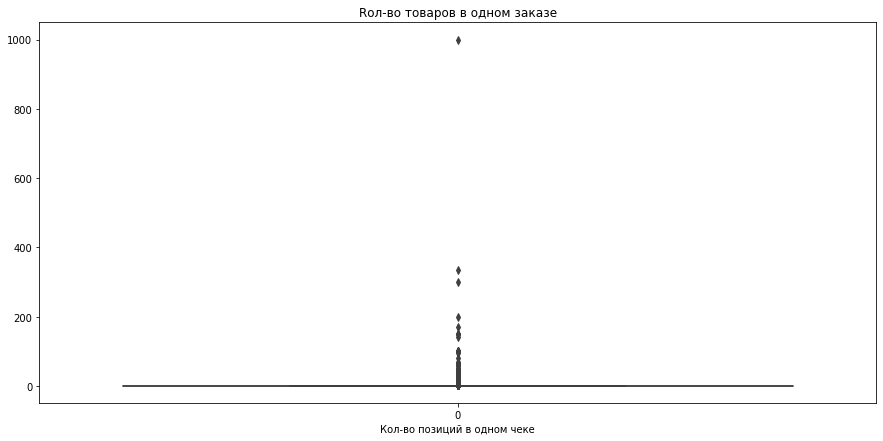

In [12]:
#Найдем самые большие по кол-ву заказы
plt.figure(figsize=(15, 7))
sb.boxplot(data=df_new['quantity'])
plt.xlabel("Кол-во позиций в одном чеке")
plt.title("Rол-во товаров в одном заказе")
plt.show()

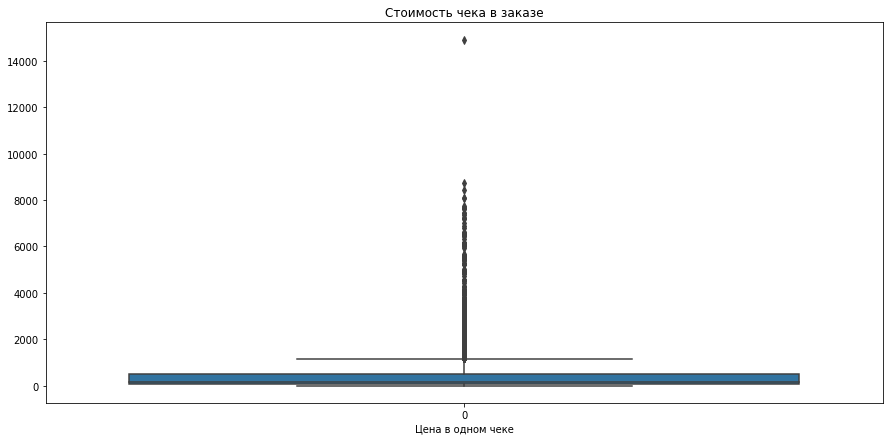

In [13]:
#Найдем самый большие по цене покупки
plt.figure(figsize=(15, 7))

sb.boxplot(data=df_new['price'])

plt.xlabel("Цена в одном чеке")
plt.title("Стоимость чека в заказе")

plt.show()

Уберем выборсы по данным

In [14]:
df_new.sort_values('quantity',ascending=False).head(5)

,date,customer_id,order_id,product,quantity,price,coast
3840,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,675000.0
3772,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,49432.0
3390,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.0,15300.0
1014,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0,5800.0
485,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0,8670.0


Только в одном заказе было больше 350 позиций, так что уберем его для точности иследования

In [15]:
# Убираем выборсы
df_new = df_new[df_new['quantity'] <= 350]

Так же удалим выбросы для цены

In [16]:
df_new.sort_values('coast',ascending=False).head(5)

,date,customer_id,order_id,product,quantity,price,coast
3772,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,49432.0
1303,2019-01-15 13:00:00,58a4c3cc-504f-43ea-a74a-bae19e665552,69830,Простынь вафельная 200х180 см WELLNESS RW180-0...,27,1755.0,47385.0
1138,2018-12-21 16:00:00,6987e6d6-a63a-4ce2-a2d0-f424092d235e,69504,Тележка багажная DELTA ТБР-22 синий грузоподъе...,57,574.0,32718.0
897,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,Набор ножей Attribute CHEF 5 предметов AKF522,64,457.0,29248.0
571,2018-11-06 12:00:00,1b2764ad-9151-4051-a46a-9b01b62e6335,68878,"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см...",5,4874.0,24370.0


Выбросов по цене не наблюдается, это могут быть оптовые клиенты

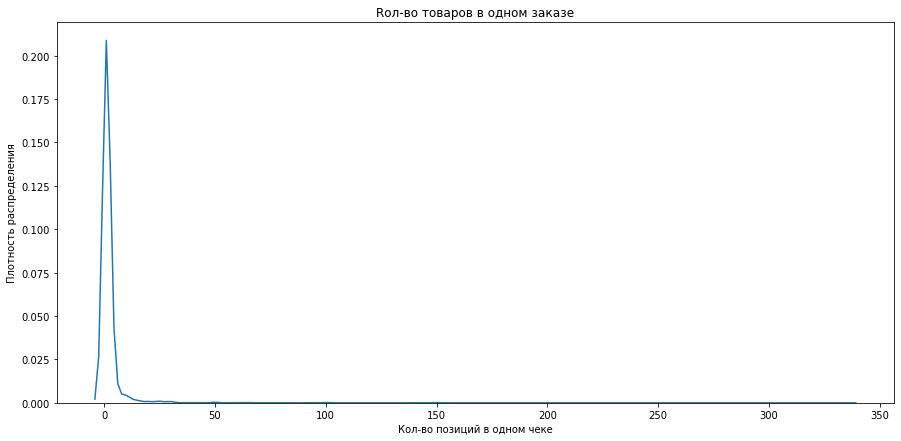

In [17]:
#Найдем самые большие по кол-ву заказы
plt.figure(figsize=(15, 7))
sb.kdeplot(data=df_new['quantity'])
plt.xlabel("Кол-во позиций в одном чеке")
plt.ylabel("Плотность распределения")
plt.title("Rол-во товаров в одном заказе")
plt.show()

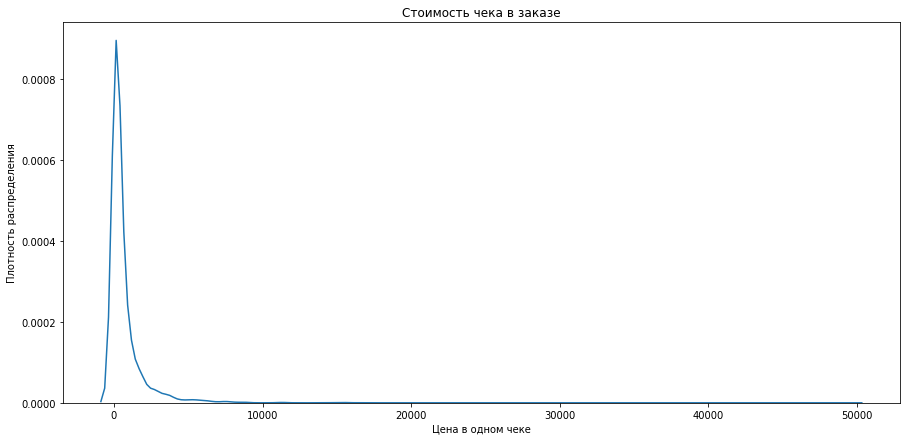

In [18]:
#Найдем самый большие по цене покупки
plt.figure(figsize=(15, 7))

sb.kdeplot(data=df_new['coast'])

plt.xlabel("Цена в одном чеке")
plt.ylabel("Плотность распределения")
plt.title("Стоимость чека в заказе")

plt.show()

**Вывод:** \
    - Почти в каждом заказе находится до 4 позиций, но так же есть много заказов где больше\
    - Цена чека обычно составляет до 1000

### Топ покупателей 

#### По сумме покупок

Находим топ-10 покупателей по сумме покупок и количчеству покупок

In [19]:
#Строим таблицу покупателей с самым большим чеком и количеством покупок
df_new.groupby('customer_id').agg({'coast':'sum','quantity':'sum'}).sort_values('coast', ascending=False).head(10)

,coast,quantity
customer_id,,
c971fb21-d54c-4134-938f-16b62ee86d3b,159508.0,334
4d93d3f6-8b24-403b-a74b-f5173e40d7db,57278.0,309
58a4c3cc-504f-43ea-a74a-bae19e665552,53232.0,30
146cd9bf-a95c-4afb-915b-5f6684b17444,49432.0,334
498f12a4-6a62-4725-8516-cf5dc9ab8a3a,41900.0,85
8fba3604-ef57-4b9f-b2fe-3402fa8825c8,33680.0,101
6987e6d6-a63a-4ce2-a2d0-f424092d235e,32718.0,57
1b2764ad-9151-4051-a46a-9b01b62e6335,24370.0,5
9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,22056.0,47


**Выводы по анализу данных:**\
    - Были удалены из исследования данные о заказах в которых было больше чем 350 позиций, так как такой заказ только 1 и его можно считать за выброс\
    - После удаление выбросов, можно заметить, что позиций в чеке обычно не больше 4, а цена до 1000.\
    - Чем больше у покупателя суммарный чек - тем больше позиций он покупает.

## Сегментация пользователей

### Деление товаров на категории

In [20]:
#Привидем все названия к нижнему регистру для упрощения деления на группы
df_new['product'] = [product.lower() for product in df_new['product']]

In [21]:
#Также заменим все ё на е
df_new['product'] = [product.replace('ё', 'е') for product in df_new['product']]

Делим товары на категории, можно операться на данные по сезнности, потому что в основном похожие товары продаются в одном сезоне

In [22]:
#Посмотрим на уникальные значения в названии товаров
print("Уникальных товаров: ", df_new['product'].nunique())

Уникальных товаров:  2331


In [23]:
#Посмотрим какие товары чаще всего встречаются
sorted_counts = sorted(Counter(df_new['product']).items(), key=lambda x: x[1], reverse=True)
sorted_counts

[('пеларгония розебудная red pandora укорененный черенок', 65),
 ('пеларгония розебудная prins nikolai укорененный черенок', 54),
 ('пеларгония зональная диам. 12 см сиреневый полумахровый', 53),
 ('сумка-тележка 2-х колесная gimi argo синяя', 47),
 ('пеларгония розебудная mary укорененный черенок', 40),
 ('пеларгония розебудная queen ingrid укорененный черенок', 31),
 ('пеларгония розебудная margaretha укорененный черенок', 31),
 ('пеларгония зональная махровая лососевая', 25),
 ('пеларгония зональная ринго вайт d-7 см h-10 см укорененный черенок', 25),
 ('пеларгония зональная диам. 12 см коралловая полумахровая', 24),
 ('пеларгония зональная диам. 12 см темнорозовая полумахровая', 22),
 ('пеларгония зональная диам. 12 см красная махровая', 21),
 ('однолетнее растение петуния махровая в кассете 4 шт, россия', 20),
 ('пеларгония розебудная rosebud red d-7 см', 18),
 ('сушилка для белья настенная zalger prima 510-720 веревочная 7 линий 25 м',
  17),
 ('тележка багажная delta тбр-20 сини

Почти у всех товаров первые два-три слова отражают общий смысл товара, так что сделаем такую же сортировку по ним

In [24]:
#Посмотрим на самые используемые первых 3 слова
product = [' '.join(item.split()[:3]) for item in df_new['product']]
sorted_counts = sorted(Counter(product).items(), key=lambda x: x[1], reverse=True)
sorted_counts

[('сушилка для белья', 293),
 ('пеларгония зональная диам.', 276),
 ('рассада зелени для', 236),
 ('герань домашняя (пеларгония', 112),
 ('сумка-тележка 2-х колесная', 98),
 ('тележка багажная delta', 87),
 ('гладильная доска ника', 80),
 ('штора для ванной', 73),
 ('пеларгония розебудная red', 65),
 ('чехол для гладильной', 64),
 ('сумка-тележка хозяйственная rolser', 54),
 ('пеларгония розебудная prins', 54),
 ('сумка-тележка хозяйственная gimi', 47),
 ('пеларгония зональная махровая', 46),
 ('рассада арбуза сорт', 42),
 ('рассада капусты белокачанная', 41),
 ('пеларгония розебудная mary', 40),
 ('пеларгония toscana angeleyes', 40),
 ('петуния махровая рассада', 38),
 ('корзина для белья', 31),
 ('пеларгония розебудная queen', 31),
 ('пеларгония розебудная margaretha', 31),
 ('роза садовая чайногибридная', 31),
 ('рассада огурца сорт', 31),
 ('рассада кабачка сорт', 30),
 ('однолетнее растение петуния', 28),
 ('рассада томата (помидор)', 26),
 ('рассада дыни сорт', 26),
 ('чехол для 

Из этих данных можно выделить такие категории для деления товаров:\
    - Дача и уличная рассада (это рассада, черенки, семена, кашпо, сумки, все для дачи и т.п.)\
    - Домашняя рассада и все для нее (это рассада, вазы и т.п.)
    - Вещи для дома (гладильные доски, коврики, корзины и т.п.)\
    - Вещи для ванны (Мыло, тряпки, маски для лица, фен и т.п.)
    - Кухонные принадлежности (ножи, сковородки, чайник и т.п.)\
    - Ремонт (стремянка, полка и т.п.)

In [25]:
#Зададим ключевые слова для каждой категории, чтобы разделить их
dacha = ['арбуз', 'веник', 'вербейник', 'вербена', 'веревка', 'виола','девичий', 'дыня', 'ель', 'зола','календула','калибрахоа',
         'камнеломка','кассета', 'кашпо', 'кипарисовик', 'клен', 'клубника', 'колокольчик', 'колосковый', 'кореопсис', 'корыто',
         'котовник','лапчатка', 'лен', 'лилейник','многолетний', 'монарда', 'настурция','нивянник', 'осина', 'папоротник',
         'пикник','пиретрум', 'платикодон','рассада', 'роза','рудбекия','садовый', 'седум', 'солидаго',  'томат', 'тюльпан',
         'уличный','урна', 'урна-пепельница', 'физостегия','флокс','хоста', 'хризантема', 'цинния', 'черенок', 'щетка-сметка',
         'энотера','эхинацея','ясколка','калла','лавр','кориандр', 'базилик', 'космея','петрушка','растение','капуста',
         'вероника', 'валериан','любисток','шалфей', 'цинерария', 'сумка', 'тележка', 'почтовый','ведро', 'таз',
         'диффенбахия','тележк','бензин','огурец','салат','смолевка','змееголовник','гайлардия','лилиана','морковь','годеция',
        'укроп','незабудка','тимьян','эшшольция','маттиола','горох','земляника','лаватера']

plants_house = ['d-','искусственн','комнатный','декоратив','аквилегия', 'алиссум', 'анемон', 'антуриум',
         'астра', 'бадан', 'бакоп', 'барвинок', 'бегония', 'бузульник','гайлардий','гвоздик', 'георгин','гипсофил', 'гортензия',
         'дендробиум','лобелия','пеларгония','петуния','ранункулус','фуксия','муляж','цикламен','примула','горшке',]

house = ['мусор', 'мусорный', 'бак','ваза','весы','вешалк','вещь','гладильный','глажение', 'засор','ключница','ковер','ковр',
         'ковш', 'кондиционер', 'корзина', 'коробка', 'кофр', 'крючок','наволочка','наматрацник', 'наматрасник', 'насадка',
         'одеяло', 'окномойка', 'отбеливатель','плед', 'плечики','подголовник', 'пододеяльник', 'подрукавник', 'подушка',
         'покрывало', 'пол','полировка', 'постельный','прищепок', 'простыня', 'пятно', 'радиаторный','ролик','светильник',
         'совок', 'сушилка','тряпкодержатель', 'утюг', 'фоторамка', 'хранение', 'чехол', 'щетка', 'шило', 'штор','дома','ящик',
         'перчатк','вешалок','мыльниц','пылесос','маска','отжим','хранения','корзинка','стирки', 'салфетка','гладильн',
         'глажения']

bathroom = ['мыло', 'зубной', 'вантуз','лоток','стиральный','полотенце', 'туалет', 'унитаз','фен','халат', 'швабра', 'мыла',
         'сиденье','антижир','паста','ванн','чистящий крем','чистк']

kitchen = ['пьезозажигалка', 'банка', 'бидон', 'блюд', 'бокал', 'бульонница', 'бутыл', 'венчик','вилка', 'выпечка',
         'герметичный', 'губка', 'измельчитель', 'картофелемялка', 'кастрюля', 'кекс','кипятильник','кондитерский', 'кружка',
         'крышка', 'кухонный', 'лопатка', 'ложка', 'мантоварка', 'миксер','сковорода','миска','мука','нож', 'овоще','овсянница',
         'орехоколка', 'отделитель', 'посуд','пресс', 'продукт', 'противень', 'разделочн','рыбочистка', 'салатник','салфетница',
         'сахарница', 'свч','сито', 'скалка', 'скатерть', 'соковарка', 'соковыжималка','сотейник','стакан','столовый','тарелка',
         'терка', 'термокружок', 'термос', 'толкушка', 'тортница', 'фужер', 'хлебница','чайн', 'электроштопор', 'яйцо', 'котел',
         'выпечк', 'салфетк', 'столовых', 'кувшин','соус','полимербыт','скребок','круже','салфет','микрофибр']

repair = ['болт','фал','шнур', 'шпагат', 'вентиляционный', 'инструмент', 'карниз', 'комод', 'крепеж', 'лестница-стремянка',
        'линейка', 'линейка','мебельный', 'напильник', 'обувница', 'петля', 'подставка', 'полк', 'пробка', 'пуф','сварка',
        'стеллаж','стремянк', 'строительный','уголок', 'угольник', 'фиксатор-шар', 'форточный', 'шпингалет','штангенциркуль',
        'этажерка','сверел','пена','сметк','вентиляционная','пробки','ручка','сверл']

In [26]:
#Напишем функцию для кластеризации данных
def category(name):
    categories = {
        'Дача': dacha,
        'Домашние растения' : plants_house,
        'Вещи для дома': house,
        'Вещи для ванной' : bathroom,
        'Кухня': kitchen,
        'Ремонт': repair
    }

    for category, keywords in categories.items():
        if any(keyword in name for keyword in keywords):
            return category

    return 'Нет категории'

In [27]:
#Создадим новый столбец с данными
df_new['category'] = df_new['product'].apply(category)

In [28]:
#Посмотрим как распределились группы
df_new['category'].value_counts()

Дача                 2971
Домашние растения    1171
Вещи для дома         832
Кухня                 355
Вещи для ванной       108
Ремонт                106
Name: category, dtype: int64

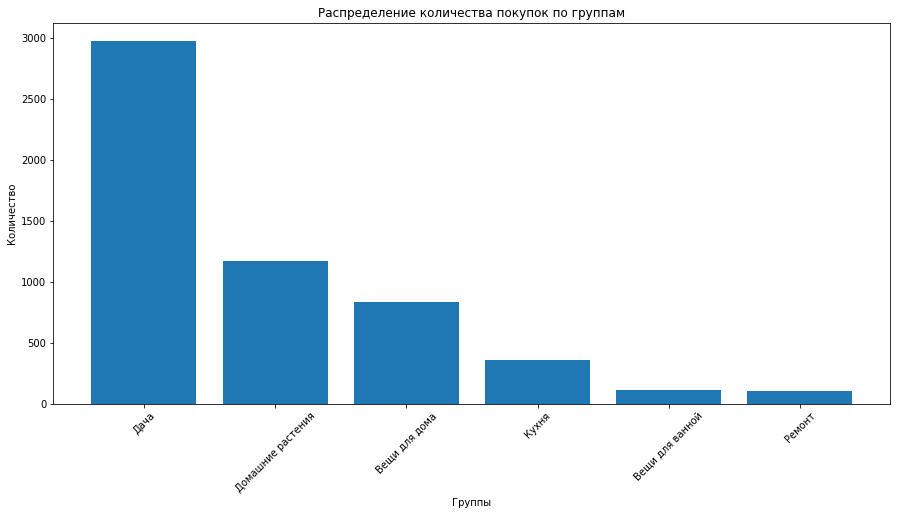

In [29]:
labels = df_new['category'].value_counts().index
sizes = df_new['category'].value_counts().values
plt.figure(figsize=(15, 7))
plt.bar(labels, sizes)
plt.xlabel('Группы')
plt.ylabel('Количество')
plt.title('Распределение количества покупок по группам')
plt.xticks(rotation=45)  # Поворот надписей на оси x, если не все помещаются
plt.show()

**Самые популярные категории по количеству покупок это дача и домашние растения**\
Проверим так же другие показатели по группам

In [30]:
#Создадим группировку по категориям, чтобы посмотреть на стоимость продаж
grouped_category = df_new.groupby([df_new['date'].dt.to_period('M'), 'category'])['coast'].sum().reset_index()

In [31]:
#Делаем таблицу для построения графика
table_category = grouped_category.pivot(index='date', columns='category', values='coast')

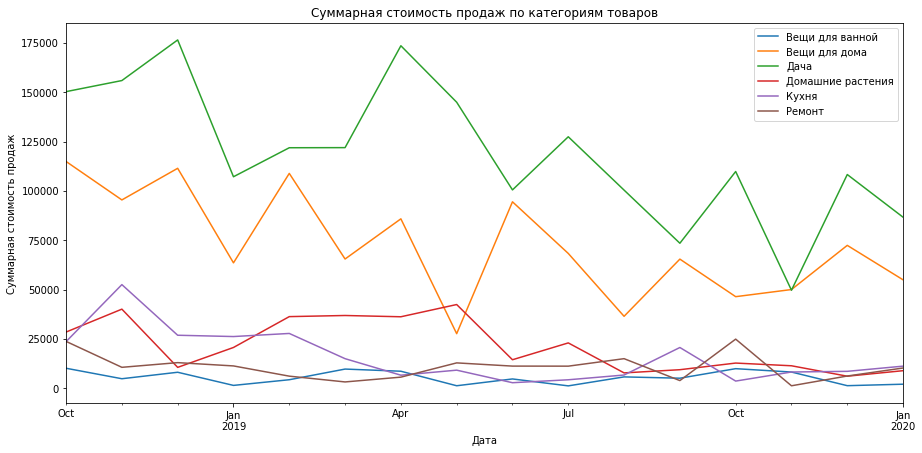

In [32]:
#Строим график по суммарным продажам за весь период
table_category.plot(kind='line', figsize=(15, 7))
plt.xlabel('Дата')
plt.ylabel('Суммарная стоимость продаж')
plt.title('Суммарная стоимость продаж по категориям товаров')
plt.legend()
plt.show()

Категории **Дача** и **Вещи для дома** имеют намного больше продаж чем все остальные. В начале была очень большая суммарная стоимость продаж у двух самых больших категорий, скорее всего это связано с оптовыми покупателями.

### Создаем кластеры 

Используя систему RFM-анализа разделяем клиентов на кластеры по покупакам 

In [33]:
#Зададим максимальную дату
last_date = df_new['date'].max()

In [34]:
#Создадим таблицу для RFM анализа где будут показаны недавность покупки, частота покупок и сумма покупок
rfm = df_new.groupby('customer_id').agg({
    'date': lambda x: (last_date - x.max()).days,  # Recency - недавность покупки
    'order_id': 'nunique',  # Frequency - частота покупок
    'coast': 'sum'  # Monetary - сумма покупок
}).reset_index()

In [35]:
#Переименуем столбцы
rfm.rename(columns={
    'date': 'Recency',
    'order_id': 'Frequency',
    'coast': 'Monetary'
}, inplace=True)

In [36]:
#Разброс кол-ва покупок
rfm['Frequency'].unique()

array([  1,   2,   5,   3,   4,  35,  17,   7, 126])

In [37]:
#Так как в столбце Frequency очень малые разброс значений нам надо вручную задать диапазон
bin_edges = [0, 4, 10, 20, float('inf')]

In [38]:
#Разобъем данные в Recency, Frequency, Monetary на 4 категории
rfm['R'] = pd.qcut(rfm['Recency'], 4, ['4', '3', '2', '1'])  # 4 - самый недавний, 1 - самый давний
rfm['F'] = pd.cut(rfm['Frequency'], bins=bin_edges, labels=['1', '2', '3', '4']).sort_values()  # 4 - наибольшая частота, 1 - наименьшая частота
rfm['M'] = pd.qcut(rfm['Monetary'], 4, ['1', '2', '3', '4'])  # 4 - наибольшая сумма, 1 - наименьшая сумма

In [39]:
#Создадим суммарный столбец RFM анализа
rfm['RFM'] = rfm['R'].astype(int) + rfm['F'].astype(int) + rfm['M'].astype(int)
rfm.sort_values('RFM', ascending=False)

,customer_id,Recency,Frequency,Monetary,R,F,M,RFM
1079,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,92,17,21361.0,3,3,4,10
1884,c971fb21-d54c-4134-938f-16b62ee86d3b,331,126,159508.0,2,4,4,10
958,671a745b-22d3-4724-af7b-f5357b586407,59,2,2137.0,4,1,4,9
466,3270f879-7932-410c-ac87-82ff83ea457b,33,2,6073.0,4,1,4,9
2280,f279d50f-a508-40b4-bde5-5cb4a1be3ad0,31,2,16557.0,4,1,4,9
...,...,...,...,...,...,...,...,...
1837,c3e67a34-7b23-4fba-aefd-265fa2957b38,359,1,134.0,1,1,1,3
2275,f1cb90a3-c0d7-463b-bf85-a17711939a69,446,2,268.0,1,1,1,3
541,395aeb0e-dab1-4dbd-8cbc-219ba2536e8a,366,1,127.0,1,1,1,3
894,60aac78f-d7f0-4075-a26e-d28b4b98d4a6,352,1,157.0,1,1,1,3


**Вывод:**\
    - Товары были разделены на 4 категории (Дача и уличная рассада, Домашняя рассада, Вещи для дома, Вещи для ванны, Кухонные принадлежности, Ремонт)\
    - Самые популярные из этих категорий - Дача и уличная рассада и Домашняя рассада, они лидируют по кол-ву товаров и по суммарным продажам\
    - Сегментация пользователей проходила по RFM анализу, были выделены 4 категории по Recency  - Недавность покупки, Frequency - частота покупок, Monetary - сумма покупок

## Анализ результатов после сегментации

**Проверка кластеров покупателей:**
 - Построение визуализации для сравнения кластеров между собой
 - Нахождение общих для всех кластеров критериев для выбора клиента которому целесообразно делать рассылку 
 - Связываем кластеры с категориями товаров и их сезонностью

### Деление клиентов на группы

In [40]:
#Добавим полученные столбцы в основную таблицу
df_rfm = pd.merge(df_new, rfm[['customer_id','R','F','M','RFM']], on=['customer_id'])
df_rfm[['R','F','M','RFM']] = df_rfm[['R','F','M','RFM']].astype('int')

In [41]:
# Добавить столбец с группой на основе суммарного значения RFM
df_rfm['rfm_group'] = pd.qcut(df_rfm['RFM'], q=4, labels=['Неактуальные покупатели', 'Редкие покупатели', 'Выше среднего',
                                                          'Лучшие клиенты'])
df_rfm.head()

,date,customer_id,order_id,product,quantity,price,coast,category,R,F,M,RFM,rfm_group
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,142.0,Дача,1,1,3,5,Неактуальные покупатели
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,194.0,Дача,1,1,3,5,Неактуальные покупатели
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,112.0,Домашние растения,1,1,3,5,Неактуальные покупатели
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,179.0,Домашние растения,1,1,3,5,Неактуальные покупатели
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,112.0,Домашние растения,1,1,3,5,Неактуальные покупатели


In [42]:
#Группируем категории по RFM анализу
rfm_group = df_rfm.groupby(['category','rfm_group'])[['R','F','M','RFM']].mean().reset_index()

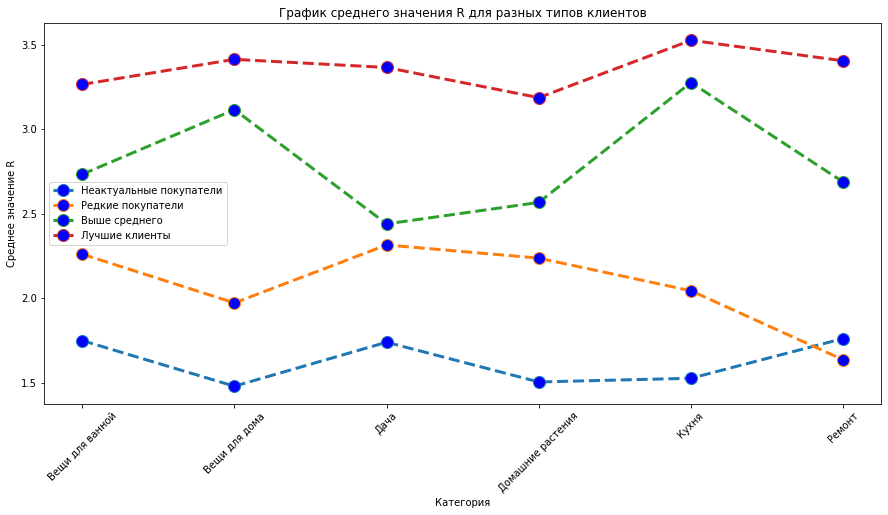

In [43]:
#Построение графика для Недавность покупки
categories = rfm_group['category'].unique()
group = rfm_group['rfm_group'].unique()
plt.figure(figsize=(15, 7))
for i in group:
    values = rfm_group[rfm_group['rfm_group'] == i]['R']
    plt.plot(categories, values, label=rfm_group, linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue',
             markersize=12)
plt.xlabel('Категория')
plt.ylabel('Среднее значение R')
plt.title('График среднего значения R для разных типов клиентов')

plt.legend(rfm_group['rfm_group'])

plt.xticks(rotation=45)

plt.show()

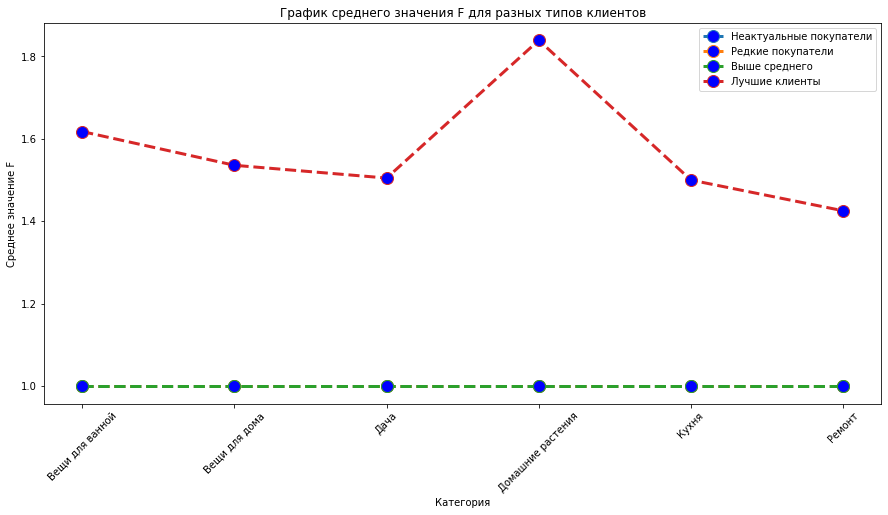

In [44]:
#Построение графика для Частоты покупок
plt.figure(figsize=(15, 7))
for i in group:
    values = rfm_group[rfm_group['rfm_group'] == i]['F']
    plt.plot(categories, values, label=rfm_group, linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue', markersize=12)
plt.xlabel('Категория')
plt.ylabel('Среднее значение F')
plt.title('График среднего значения F для разных типов клиентов')

plt.legend(rfm_group['rfm_group'])

plt.xticks(rotation=45)

plt.show()

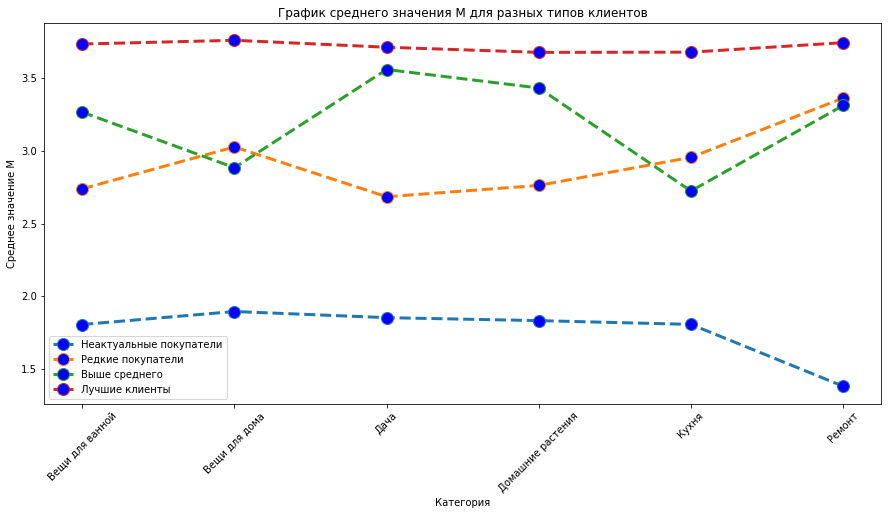

In [45]:
#Построение графика для Суммы покупок
plt.figure(figsize=(15, 7))
for i in group:
    values = rfm_group[rfm_group['rfm_group'] == i]['M']
    plt.plot(categories, values, label=rfm_group, linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue', markersize=12)
plt.xlabel('Категория')
plt.ylabel('Среднее значение M')
plt.title('График среднего значения M для разных типов клиентов')

plt.legend(rfm_group['rfm_group'])

plt.xticks(rotation=45)

plt.show()

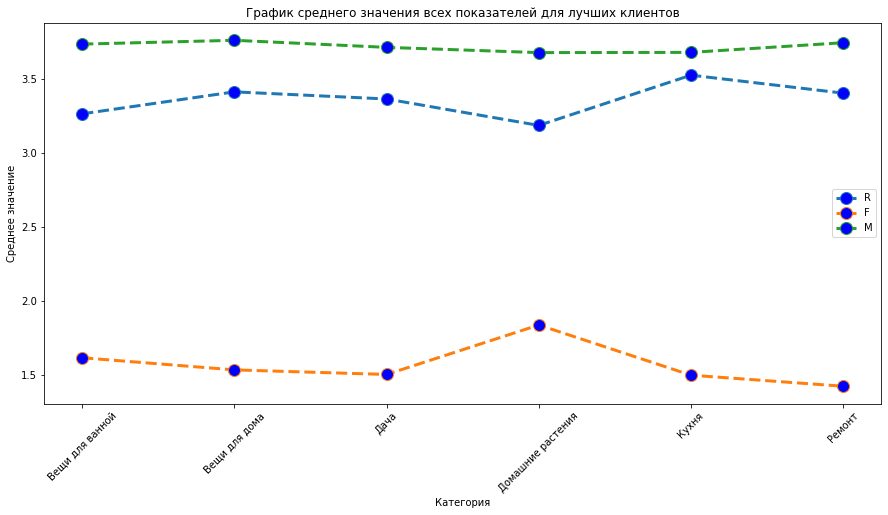

In [46]:
#Построение графика всех показателей для лучших клиентов
plt.figure(figsize=(15, 7))
plt.plot(categories, rfm_group[rfm_group['rfm_group'] == 'Лучшие клиенты'][['R','F','M']], label=rfm_group, linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='blue', markersize=12)
plt.xlabel('Категория')
plt.ylabel('Среднее значение')
plt.title('График среднего значения всех показателей для лучших клиентов')

plt.legend(rfm_group[['R','F','M']])

plt.xticks(rotation=45)

plt.show()

**Для оптовых покупателей:**
 - Главное чтобы у клиента была большая сумма покупок. Частота и Недавность покупок не так важны, так как оптовые покупатели обычно, покупают много, но редко.
 
**Для постоянных клиентов:**
 - Главным критерием является частота покупок.

### Отслеживания сезоности категорий

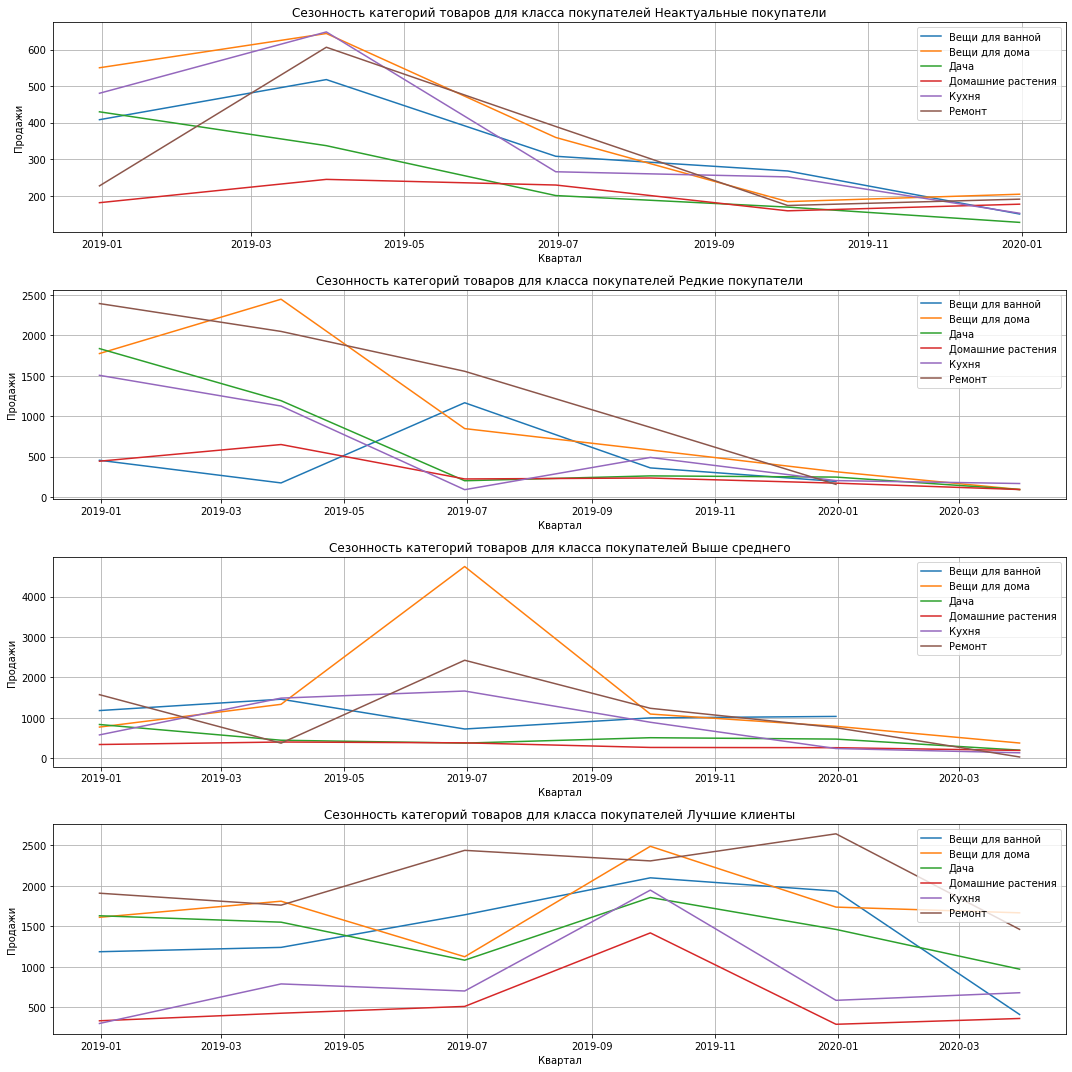

In [47]:
# Создание 4 графиков
customer_classes = ["Неактуальные покупатели", "Редкие покупатели", "Выше среднего", "Лучшие клиенты"]

fig, axes = plt.subplots(4, 1, figsize=(15, 15))

# Итерация по каждому классу покупателей
for i, customer_class in enumerate(customer_classes):
    # Получение данных по кварталам для текущего класса покупателей
    data = df_rfm[df_rfm["rfm_group"] == customer_class].groupby(['category', pd.Grouper(key='date', freq='Q')])\
    ['coast'].mean().reset_index()
    
    # Построение графика
    ax = axes[i]
    for category in data['category'].unique():
        category_data = data[data['category'] == category]
        ax.plot(category_data['date'], category_data['coast'], label=category)

    ax.legend()
    ax.set_xlabel("Квартал")
    ax.set_ylabel("Продажи")
    ax.set_title(f"Сезонность категорий товаров для класса покупателей {customer_class}")
    ax.grid(True)

# Размещение графиков на фигуре
plt.tight_layout()

# Отображение графиков
plt.show()


**Выводы:**
- У "Неактуальных покупателей" был скачок продаж в категориях "Вещи для дома", "Кухня", "Ремонт", "Вещи для ванной" 2019-04, возможно это была одиночная оптовая покупка
- У Редких покупателей был скачек только по категории "Вещи для дома"
- У покупателей "Выше среднего" скачок был 2019-07 по категориям "Вещи для дома", "Ремонт"
- У "Лучших клиентов" скачек был 2019-10 по категориям "Домашние растения", "Кухня", "Вещи для дома".

- Сезонность можно отследить только для категории "Дача" - с мая по сентябрь. Остальные категории продаются весь год

## Статистические гипотезы

С помощью гипотез мы можем проверить правильность формирования кластеров потребителей.\
Получаем две гипотезы 

**Первая гипотеза**:\
    H0 - Средний чек по кластерам не различается\
    H1 - Средний чек по кластерам различается\
**Вторая гипотеза**:\
    H0 - в каждом кластере среднее кол-во покупок не имеет статической значимой разницы \
    H1 - средние значения среднего кол-во покупок имеет статическую значимую разницу.

In [48]:
#Зададим p-значение с учетом множественных проверок
alpha = 0.05
alpha = 1-(1-alpha)**(1/10)
alpha

0.005116196891823743

In [49]:
#Проверка первой гипотезы
cluster_low = df_rfm[df_rfm['rfm_group'] == 'Неактуальные покупатели']
cluster_med = df_rfm[df_rfm['rfm_group'] == 'Редкие покупатели']
cluster_high = df_rfm[df_rfm['rfm_group'] == 'Выше среднего']
cluster_top = df_rfm[df_rfm['rfm_group'] == 'Лучшие клиенты']



t_statistic, p_value = stats.mannwhitneyu(cluster_low['coast'], cluster_med['coast'])

# Вывод результатов теста
print('Сравнение Неактуальных покупателей и редких покупателей')
print()
print('t-статистика: {:.2f}'.format(t_statistic))
print('p-значение: {:.4f}'.format(p_value))
print(f"Средний чек в cluster_low: {cluster_low['coast'].mean():.2f}")
print(f"Средний чек в cluster_med: {cluster_med['coast'].mean():.2f}")
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print()
t_statistic, p_value = stats.mannwhitneyu(cluster_med['coast'], cluster_high['coast'])

# Вывод результатов теста
print('Сравнение редких покупателей и покупателей выше среднего')
print()
print('t-статистика: {:.2f}'.format(t_statistic))
print('p-значение: {:.4f}'.format(p_value))
print(f"Средний чек в cluster_med: {cluster_med['coast'].mean():.2f}")
print(f"Средний чек в cluster_high: {cluster_high['coast'].mean():.2f}")
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print()
t_statistic, p_value = stats.mannwhitneyu(cluster_high['coast'], cluster_top['coast'])

# Вывод результатов теста
print('Сравнение покупателей выше среднего и лучших клиентов')
print()
print('t-статистика: {:.2f}'.format(t_statistic))
print('p-значение: {:.6f}'.format(p_value))
print(f"Средний чек в cluster_high: {cluster_high['coast'].mean():.2f}")
print(f"Средний чек в cluster_top: {cluster_top['coast'].mean():.2f}")
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

t_statistic, p_value = stats.mannwhitneyu(cluster_low['coast'], cluster_high['coast'])
# Вывод результатов теста
print('Сравнение Неактуальных покупателей и покупателей выше среднего')
print()
print('t-статистика: {:.2f}'.format(t_statistic))
print('p-значение: {:.4f}'.format(p_value))
print(f"Средний чек в cluster_low: {cluster_low['coast'].mean():.2f}")
print(f"Средний чек в cluster_high: {cluster_high['coast'].mean():.2f}")
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print()
t_statistic, p_value = stats.mannwhitneyu(cluster_low['coast'], cluster_top['coast'])
# Вывод результатов теста
print('Сравнение Неактуальных покупателей и Лучших покупателей')
print()
print('t-статистика: {:.2f}'.format(t_statistic))
print('p-значение: {:.4f}'.format(p_value))
print(f"Средний чек в cluster_low: {cluster_low['coast'].mean():.2f}")
print(f"Средний чек в cluster_top: {cluster_top['coast'].mean():.2f}")
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print()
t_statistic, p_value = stats.mannwhitneyu(cluster_med['coast'], cluster_top['coast'])
# Вывод результатов теста
print('Сравнение покупателей редких покупателй и лучших клиентов')
print()
print('t-статистика: {:.2f}'.format(t_statistic))
print('p-значение: {:.6f}'.format(p_value))
print(f"Средний чек в cluster_med: {cluster_med['coast'].mean():.2f}")
print(f"Средний чек в cluster_top: {cluster_top['coast'].mean():.2f}")
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Сравнение Неактуальных покупателей и редких покупателей

t-статистика: 1082779.00
p-значение: 0.0865
Средний чек в cluster_low: 306.37
Средний чек в cluster_med: 681.23
Не получилось отвергнуть нулевую гипотезу

Сравнение редких покупателей и покупателей выше среднего

t-статистика: 969480.50
p-значение: 0.6081
Средний чек в cluster_med: 681.23
Средний чек в cluster_high: 591.27
Не получилось отвергнуть нулевую гипотезу

Сравнение покупателей выше среднего и лучших клиентов

t-статистика: 440739.00
p-значение: 0.000000
Средний чек в cluster_high: 591.27
Средний чек в cluster_top: 1414.23
Отвергаем нулевую гипотезу
Сравнение Неактуальных покупателей и покупателей выше среднего

t-статистика: 1046614.00
p-значение: 0.1815
Средний чек в cluster_low: 306.37
Средний чек в cluster_high: 591.27
Не получилось отвергнуть нулевую гипотезу

Сравнение Неактуальных покупателей и Лучших покупателей

t-статистика: 440341.00
p-значение: 0.0000
Средний чек в cluster_low: 306.37
Средний чек в cluster_to

In [50]:
t_statistic, p_value = stats.mannwhitneyu(cluster_low['quantity'], cluster_med['quantity'])

# Вывод результатов теста
print('Сравнение неактуальных покупателей и редких покупателей')
print()
print('t-статистика: {:.2f}'.format(t_statistic))
print('p-значение: {:.4f}'.format(p_value))
print(f"Среднее количество покупок в cluster_low: {cluster_low['quantity'].mean():.2f}")
print(f"Среднее количество покупок в cluster_med: {cluster_med['quantity'].mean():.2f}")
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print()
t_statistic, p_value = stats.mannwhitneyu(cluster_med['quantity'], cluster_high['quantity'])

# Вывод результатов теста
print('Сравнение редких покупателей и покупателей выше среднего')
print()
print('t-статистика: {:.2f}'.format(t_statistic))
print('p-значение: {:.4f}'.format(p_value))
print(f"Среднее количество покупок в cluster_med: {cluster_med['quantity'].mean():.2f}")
print(f"Среднее количество покупок в cluster_high: {cluster_high['quantity'].mean():.2f}")
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print()
t_statistic, p_value = stats.mannwhitneyu(cluster_high['quantity'], cluster_top['quantity'])

# Вывод результатов теста
print('Сравнение покупателей выше среднего и лучших клиентов')
print()
print('t-статистика: {:.2f}'.format(t_statistic))
print('p-значение: {:.6f}'.format(p_value))
print(f"Среднее количество покупок в cluster_high: {cluster_high['quantity'].mean():.2f}")
print(f"Среднее количество покупок в cluster_top: {cluster_top['quantity'].mean():.2f}")
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print()
t_statistic, p_value = stats.mannwhitneyu(cluster_low['quantity'], cluster_high['quantity'])
# Вывод результатов теста
print('Сравнение Неактуальных покупателей и покупателей выше среднего')
print()
print('t-статистика: {:.2f}'.format(t_statistic))
print('p-значение: {:.4f}'.format(p_value))
print(f"Среднее количество покупок в cluster_low: {cluster_low['quantity'].mean():.2f}")
print(f"Среднее количество покупок в cluster_high: {cluster_high['quantity'].mean():.2f}")
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print()
t_statistic, p_value = stats.mannwhitneyu(cluster_low['quantity'], cluster_top['quantity'])
# Вывод результатов теста
print('Сравнение Неактуальных покупателей и Лучших покупателей')
print()
print('t-статистика: {:.2f}'.format(t_statistic))
print('p-значение: {:.4f}'.format(p_value))
print(f"Среднее количество покупок в cluster_low: {cluster_low['quantity'].mean():.2f}")
print(f"Среднее количество покупок в cluster_top: {cluster_top['quantity'].mean():.2f}")
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print()
t_statistic, p_value = stats.mannwhitneyu(cluster_med['quantity'], cluster_top['quantity'])
# Вывод результатов теста
print('Сравнение редких покупателей и лучших клиентов')
print()
print('t-статистика: {:.2f}'.format(t_statistic))
print('p-значение: {:.6f}'.format(p_value))
print(f"Среднее количество покупок в cluster_med: {cluster_med['quantity'].mean():.2f}")
print(f"Среднее количество покупок в cluster_top: {cluster_top['quantity'].mean():.2f}")
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Сравнение неактуальных покупателей и редких покупателей

t-статистика: 1184311.00
p-значение: 0.0005
Среднее количество покупок в cluster_low: 2.00
Среднее количество покупок в cluster_med: 3.12
Отвергаем нулевую гипотезу

Сравнение редких покупателей и покупателей выше среднего

t-статистика: 977356.50
p-значение: 0.1989
Среднее количество покупок в cluster_med: 3.12
Среднее количество покупок в cluster_high: 2.39
Не получилось отвергнуть нулевую гипотезу

Сравнение покупателей выше среднего и лучших клиентов

t-статистика: 843862.50
p-значение: 0.000522
Среднее количество покупок в cluster_high: 2.39
Среднее количество покупок в cluster_top: 2.09
Отвергаем нулевую гипотезу

Сравнение Неактуальных покупателей и покупателей выше среднего

t-статистика: 1160052.00
p-значение: 0.0000
Среднее количество покупок в cluster_low: 2.00
Среднее количество покупок в cluster_high: 2.39
Отвергаем нулевую гипотезу

Сравнение Неактуальных покупателей и Лучших покупателей

t-статистика: 1058400.50
p-

**Кластеры редких покупателей и покупателей выше среднего очень похожи, а неактуальные покупатели похожи по среднему чеку на редких покупателей**

## Выводы

**Общие выводы и Рекомендации:**\
\
**Информация по покупателям**
- **Неактуальные покупатели - Клиенты которые купили в магазине 1 раз на очень маленькую сумму и больше не возвращались**
    - Средний чек - 306.37 рублей
    - В среднем в чеке 2 позиции
    - Самые популярные категории по покупкам:
        - Дача - 720 покупок
        - Домашние растения - 483 покупок
        - Вещи для дома - 200 покупок
    - В среднем на каждого клиента приходится 1.08 покупок
    - Только у этого кластера низкая сумма покупок по категории "Ремонт" у других категорий это одна из самых прибыльных категорий. Стоит попробовать поднять количество продаваемого товара этой категории
    - Самые прибыльные категории это 'Вещи для дома' и 'Дача'. Можно поднять попробовать увеличить количество этих товаров в покупке (Предлагать два товара по цене одного и подобные акции)
    - **С учетом того, что это холодные входящие клиенты которые очень редко, а иногда вообще единожды заходят - нецелесообразно делать им рассылку спецпредложения, лучше предлагать им скидку/спецпредложение прямо в магазине**
    
- **Редкие покупатели - Покупатели у которых средний чек больше, чем у "Неактуальные покупатели"**
    - Средний чек - 681.22 рублей
    - В среднем в чеке 3 позиции
    - Самые популярные категории по покупкам:
        - Дача - 780 покупок
        - Домашние растения - 316 покупок
        - Вещи для дома - 183 покупок
    - В среднем на каждого клиента приходится 1.32 покупок
    - У данного кластера самая лучшая категория по продажам - 'Ремонт' и 'Вещи для дома', но у него очень низкая частота покупок. Стоит попробовать выслать клиентом спецпредложение для данной категории.
    
- **Выше среднего - У данного кластера разница с редкими покупателями, только в частоте покупок** 
    - Средний чек - 591.27 рублей
    - В среднем в чеке 2.4 позиции
    - Самые популярные категории по покупкам:
        - Дача - 857 покупок
        - Домашние растения - 254 покупок
        - Вещи для дома - 156 покупок
    - В среднем на каждого клиента приходится 1.5 покупок
    - У данного кластера лидируют такие категории как 'Дача', 'Домашние растения' и 'Ремонт'. 
    
- **Лучшие покупатели - самые лучшие покупатели, которые покупают чаще всех других кластеров и средний чек намного превосходит другие кластеры** 
    - Средний чек - 1414.23 рублей
    - В среднем в чеке 2.1 позиции
    - Самые популярные категории по покупкам:
        - Дача - 614 покупок
        - Домашние растения - 293 покупок
        - Вещи для дома - 118 покупок
    - В среднем на каждого клиента приходится 2.2 покупок
    - Единственный кластер, где частота покупок у всех категорий достаточно высокая
    - Категория 'Домашние растения' имеют самый большой возврат клиентов, но при этом обладает одним из самых низкий суммарных чеков. Стоит мотивировать клиентов на увеличение количества данной категории в чеке. Или наоборот, можно использовать эту категорию для привлечения клиентов в магазин.
    - 'Ремонт' и 'Домашние растения' лидируют по суммарной выручке. Нужно увеличить частоту покупок в данной категории

- **Общие рекомендации:**

    - Кластеры **Выше среднего** и **Лучшие покупатели** - самые перспективные для использования рассылки. Самые перспективные категории это - 'Ремонт', 'Домашние растения' и 'Дача'. По категории 'Дача' стоит делать рассылку ближе к началу мая
    - У всех категорий кроме 'лучших клиентов' очень низкий показатель частоты покупок. Клиентам с большим чеком необходимо давать мотивацию на повторную покупку (купон на скидку)